
# Get to Know a Dataset: CCRS MODIS Albedo at 250-m resolution and 10-day intervals

This notebook serves as a guided tour of the [CCRS MODIS Albedo at 250-m resolution and 10-day intervals ](https://registry.opendata.aws/CCRSMODISAlbedo.yml) dataset. 


### Q: How have you organized your dataset? Help us understand the key prefix structure of your S3 bucket.

Key Prefixes would start with Bucketname, like ccrs-modis-albedo; there are subfolders starting from 2000 to 2024 , which corresponds to each year. The key prefixes could be  'ccrs-modis-albedo/2000/'

A descriptive documentation prepared (https://github.com/OpsCCRS/AWS-Open-Data-Registry-Preparation/blob/main/CCRSMODISAlbedo/DescriptiveDocumentation_CCRSMODISAlbedo.pdf) describes how the data is organized, how users can find the data they need, and how users can use the data.

Full documentation for this dataset can be found at: https://data.eodms-sgdot.nrcan-rncan.gc.ca/public/CCRS/Trishchenko_MODIS_Albedo/





### The codes for different scenarios are provided for users to access the data and use the data easily: 

    1.	Print all files in Bucket
    2.	Print the names of subfolders and the number of files in each subfolder
    3.	Print file names in one subfolder, for example, 2012
    4.	Download files in a subfolder as a zip file (it is slow compared with downloading directly to a local drive without being zipped)
    5.	Download a subfolder into a local folder
    6.	Download a subfolder (2012) based on a shape file
    7.	Download subfolders based on shape file
    8.	Load files like BB_Albedo file and its State_Mask without downloading to the local
    9.	Downloaded files like BB_Albedo file and its State_Mask to the local and display 
    10.	Create false-color composite image of the area for mid-summer 2012 and show the corresponding values of shortwave (SW) broadband albedo
    11.	Create a subset of false composite, display it and see the corresponding values of shortwave (SW) broadband albedo
    12.	Create a false cloud free composite and save it in a local drive
    13.	Create a subset of false composite and save it in a local drive

#### The user will need an Anaconda virtual environment with the following coomands:
    First, start with Anaconda Prompt
    conda create --name awstest jupyterlab ipykernel geopandas rasterio boto3
    conda config --set ssl_verify false

    or use the requirement.txt provided with the following commands
    conda install pip
    pip install -r requirements.txt



In [1]:
import boto3
from botocore import UNSIGNED
from botocore.client import Config   

import warnings
import urllib3

from io import BytesIO
from zipfile import ZipFile
import os
import time

import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.io import MemoryFile
from rasterio.windows import from_bounds
from rasterio.warp import transform

from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import mapping

In [2]:
#environment setting 
os.environ["AWS_ACCESS_KEY_ID"] = ""
os.environ["AWS_SECRET_ACCESS_KEY"] = ""
os.environ["AWS_NO_SIGN_REQUEST"] = "YES"
# Disable warning
warnings.filterwarnings("ignore", category=urllib3.exceptions.InsecureRequestWarning)

#### Define the location of dataset, create boto3 S3 client.

In [3]:
# Location of the S3 bucket for this dataset
bucket_name = 'ccrs-modis-albedo'

# List the top level of the bucket using boto3. Because this is a public bucket, we don't need to sign requests.
# Here we set the signature version to unsigned, which is required for public buckets.
s3 = boto3.client(
    "s3",
    config=Config(signature_version=UNSIGNED),
    verify=False
)

#### 1. Print all files in Bucket

In [4]:
### print all files in the Bucket
response = s3.list_objects_v2(Bucket=bucket_name)
for content in response.get('Contents', []):
    print(content['Key'])

2000/Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20000301_2.5km.tif
2000/Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20000311_2.5km.tif
2000/Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20000321_2.5km.tif
2000/Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20000401_2.5km.tif
2000/Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20000411_2.5km.tif
2000/Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20000421_2.5km.tif
2000/Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20000501_2.5km.tif
2000/Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20000511_2.5km.tif
2000/Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20000521_2.5km.tif
2000/Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20000601_2.5km.tif
2000/Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20000611_2.5km.tif
2000/Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20000621_2.5km.tif
2000/Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20000701_2.5km.tif
2000/Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20000711_2.5km.tif
2000/Terra_MODIS_Alb

#### 2. Print the names of subfolers and the number of files in each subfolder

In [5]:
# print the name of subfolers and the number of files in each subfolder

# Get all first-level subfolders
subfolders = []
continuation_token = None

while True:
    if continuation_token:
        resp = s3.list_objects_v2(
            Bucket=bucket_name,
            Prefix="",
            Delimiter="/",
            ContinuationToken=continuation_token
        )
    else:
        resp = s3.list_objects_v2(
            Bucket=bucket_name,
            Prefix="",
            Delimiter="/"
        )

    # Add the prefixes (subfolders) found in this page
    for cp in resp.get("CommonPrefixes", []):
        subfolders.append(cp["Prefix"])

    # Check if more pages exist
    if resp.get("IsTruncated"):
        continuation_token = resp.get("NextContinuationToken")
    else:
        break

# Count files in each subfolder
for folder in subfolders:
    files = []
    token = None
    while True:
        if token:
            resp_files = s3.list_objects_v2(
                Bucket=bucket_name,
                Prefix=folder,
                Delimiter="/",
                ContinuationToken=token
            )
        else:
            resp_files = s3.list_objects_v2(
                Bucket=bucket_name,
                Prefix=folder,
                Delimiter="/"
            )

        # Add files (exclude subfolders)
        for obj in resp_files.get('Contents', []):
            files.append(obj['Key'].split('/')[-1])

        if resp_files.get("IsTruncated"):
            token = resp_files.get("NextContinuationToken")
        else:
            break

    print(f"Subfolder: {folder} -> Number of files: {len(files)}")


Subfolder: 2000/ -> Number of files: 690
Subfolder: 2001/ -> Number of files: 805
Subfolder: 2002/ -> Number of files: 828
Subfolder: 2003/ -> Number of files: 828
Subfolder: 2004/ -> Number of files: 828
Subfolder: 2005/ -> Number of files: 828
Subfolder: 2006/ -> Number of files: 828
Subfolder: 2007/ -> Number of files: 828
Subfolder: 2008/ -> Number of files: 828
Subfolder: 2009/ -> Number of files: 828
Subfolder: 2010/ -> Number of files: 828
Subfolder: 2011/ -> Number of files: 828
Subfolder: 2012/ -> Number of files: 828
Subfolder: 2013/ -> Number of files: 828
Subfolder: 2014/ -> Number of files: 828
Subfolder: 2015/ -> Number of files: 828
Subfolder: 2016/ -> Number of files: 828
Subfolder: 2017/ -> Number of files: 828
Subfolder: 2018/ -> Number of files: 828
Subfolder: 2019/ -> Number of files: 828
Subfolder: 2020/ -> Number of files: 828
Subfolder: 2021/ -> Number of files: 828
Subfolder: 2022/ -> Number of files: 805
Subfolder: 2023/ -> Number of files: 828
Subfolder: 2024/

#### 3. Print file names in one subfolder, for example, 2012

In [6]:
## print file in /2012
response3 = s3.list_objects_v2(
    Bucket=bucket_name,
    Prefix="2012/",       # change subfolder for differenet years
    Delimiter="/"    
)
# Extract file names (exclude folders)
file_names = [obj['Key'].split('/')[-1] for obj in response3.get('Contents', [])]

print("Files in subfolder:")
for name in file_names:
    print(name)

# Print number of files
print("Number of files:", len(file_names))

Files in subfolder:
Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20120101_2.5km.tif
Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20120111_2.5km.tif
Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20120121_2.5km.tif
Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20120201_2.5km.tif
Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20120211_2.5km.tif
Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20120221_2.5km.tif
Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20120301_2.5km.tif
Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20120311_2.5km.tif
Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20120321_2.5km.tif
Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20120401_2.5km.tif
Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20120411_2.5km.tif
Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20120421_2.5km.tif
Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20120501_2.5km.tif
Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20120511_2.5km.tif
Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20120521_2.5km.tif
Terra

#### 4. Download files in a subfolder as a zip file (it is slow compared with downloading directly to a local drive without being zipped)

In [7]:
# --- download the subfolder as a zip file ---
prefix = "2000/"           # subfolder to download
zip_filename = "2000.zip"  # local zip file to create

# List all files in the subfolder
file_keys = []
continuation_token = None

while True:
    if continuation_token:
        resp = s3.list_objects_v2(
            Bucket=bucket_name,
            Prefix=prefix,
            Delimiter="/",
            ContinuationToken=continuation_token
        )
    else:
        resp = s3.list_objects_v2(
            Bucket=bucket_name,
            Prefix=prefix,
            Delimiter="/"
        )
    
    # Collect file keys
    for obj in resp.get('Contents', []):
        file_keys.append(obj['Key'])
    
    if resp.get('IsTruncated'):
        continuation_token = resp.get('NextContinuationToken')
    else:
        break

print(f"Found {len(file_keys)} files in subfolder {prefix}")

# --- Download files with timing ---
total_start = time.time()
# --- Create ZIP ---
with ZipFile(zip_filename, 'w') as zipf:
    for key in file_keys:
        file_name = key.split('/')[-1]  # remove folder prefix
        # Download file content to memory
        obj = s3.get_object(Bucket=bucket_name, Key=key)
        data = obj['Body'].read()
        # Write into zip
        zipf.writestr(file_name, data)
        print(f"Added {file_name} to {zip_filename}")

print(f"Subfolder {prefix} downloaded as {zip_filename}")

total_end = time.time()

print(f"Total time: {total_end - total_start:.2f} seconds")

Found 690 files in subfolder 2000/
Added Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20000301_2.5km.tif to 2000.zip
Added Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20000311_2.5km.tif to 2000.zip
Added Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20000321_2.5km.tif to 2000.zip
Added Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20000401_2.5km.tif to 2000.zip
Added Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20000411_2.5km.tif to 2000.zip
Added Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20000421_2.5km.tif to 2000.zip
Added Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20000501_2.5km.tif to 2000.zip
Added Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20000511_2.5km.tif to 2000.zip
Added Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20000521_2.5km.tif to 2000.zip
Added Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20000601_2.5km.tif to 2000.zip
Added Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20000611_2.5km.tif to 2000.zip
Added Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_

#### 5. Download a subfolder into a local folder

In [8]:
# --- download a subfolder into a local folder ---
bucket = "ccrs-modis-albedo"
prefix = "2000/"               # S3 subfolder to download
local_dir = "./2000_local"     # Local folder to save files

# Make sure local folder exists
os.makedirs(local_dir, exist_ok=True)

# List all files in the subfolder
file_keys = []
continuation_token = None

while True:
    if continuation_token:
        resp = s3.list_objects_v2(
            Bucket=bucket,
            Prefix=prefix,
            Delimiter="/",
            ContinuationToken=continuation_token
        )
    else:
        resp = s3.list_objects_v2(
            Bucket=bucket,
            Prefix=prefix,
            Delimiter="/"
        )
    
    for obj in resp.get('Contents', []):
        file_keys.append(obj['Key'])
    
    if resp.get('IsTruncated'):
        continuation_token = resp.get('NextContinuationToken')
    else:
        break

print(f"Found {len(file_keys)} files in subfolder {prefix}")

# --- Download files with timing ---
total_start = time.time()

for key in file_keys:
    file_name = key.split('/')[-1]              # remove folder prefix
    local_path = os.path.join(local_dir, file_name)    
   
    s3.download_file(bucket, key, local_path)      
    print(f"Downloaded {file_name} to {local_path}")

total_end = time.time()
print(f"\nAll files downloaded to {local_dir}")
print(f"Total time: {total_end - total_start:.2f} seconds")

Found 690 files in subfolder 2000/
Downloaded Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20000301_2.5km.tif to ./2000_local\Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20000301_2.5km.tif
Downloaded Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20000311_2.5km.tif to ./2000_local\Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20000311_2.5km.tif
Downloaded Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20000321_2.5km.tif to ./2000_local\Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20000321_2.5km.tif
Downloaded Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20000401_2.5km.tif to ./2000_local\Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20000401_2.5km.tif
Downloaded Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20000411_2.5km.tif to ./2000_local\Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20000411_2.5km.tif
Downloaded Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20000421_2.5km.tif to ./2000_local\Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20000421_2.5km.tif
Downloaded Terra_MODIS_

#### 6. Download a subfolder (2012) based on a shape file 

In [9]:
prefix = "2012/"
example_key = "2012/Terra_MODIS_SW_BB_Albedo.Noon_250m_20120711.tif"
shapefile = "testarea.shp" ## changet the shape file to yours
# Construct HTTPS URL instead of /vsis3/
example_url = f"https://{bucket_name}.s3.ca-central-1.amazonaws.com/{example_key}"

## get crs informaiton for reproject shape file
with rasterio.open(example_url) as src:
    raster_crs = src.crs
    # print("Raster CRS:", raster_crs)
## read shape file    
gdf = gpd.read_file(shapefile)
gdf = gdf.to_crs(raster_crs)
geom = [mapping(g) for g in gdf.geometry]


tif_list = []

resp = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
for item in resp.get("Contents", []):
    key = item["Key"]
    if key.lower().endswith(".tif"):
        tif_list.append(key)

print("Found", len(tif_list), "files.")

out_dir = "subset_2012"
os.makedirs(out_dir, exist_ok=True)
# --- Download files with timing ---
total_start = time.time()

for key in tif_list:
    url = f"https://{bucket_name}.s3.ca-central-1.amazonaws.com/{key}"
    out_path = os.path.join(out_dir, os.path.basename(key))

    try:
        with rasterio.open(url) as src:
            out_image, out_transform = mask(src, geom, crop=True)
            out_meta = src.meta.copy()
            out_meta.update({
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform
            })

        with rasterio.open(out_path, "w", **out_meta) as dst:
            dst.write(out_image)

        print("Saved:", out_path)

    except Exception as e:
        print("Failed:", key, "->", e)

total_end = time.time()
print(f"Total time: {total_end - total_start:.2f} seconds")

Found 828 files.
Saved: subset_2012\Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20120101_2.5km.tif
Saved: subset_2012\Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20120111_2.5km.tif
Saved: subset_2012\Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20120121_2.5km.tif
Saved: subset_2012\Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20120201_2.5km.tif
Saved: subset_2012\Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20120211_2.5km.tif
Saved: subset_2012\Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20120221_2.5km.tif
Saved: subset_2012\Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20120301_2.5km.tif
Saved: subset_2012\Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20120311_2.5km.tif
Saved: subset_2012\Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20120321_2.5km.tif
Saved: subset_2012\Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20120401_2.5km.tif
Saved: subset_2012\Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20120411_2.5km.tif
Saved: subset_2012\Terra_MODIS_Albedo.Noon_Browse_FalseColo

#### 7. Download subfolders based on a shape file 

In [10]:
years = range(2012, 2015)   # 2012 to 2014, you can change to the range of years 
local_out_root = "./subset_local"   # folder to save clipped rasters
shapefile = "testarea.shp"          # AOI, you can chanage your shape file
raster_ext = (".tif",)

# Ensure output folder exists
os.makedirs(local_out_root, exist_ok=True)

# Load AOI and prepare geometry
gdf = gpd.read_file(shapefile)
# Geometry will be reprojected later to match raster CRS
geom = [mapping(gdf.geometry.union_all())]

# --- Download files with timing ---
total_start = time.time()
# -----------------------------
# Loop through years and download + clip
# -----------------------------
for year in years:
    prefix = f"{year}/"
    print(f"\n=== Processing year: {year} ===")

    # List all files in this subfolder
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
    tif_keys = [item["Key"] for item in response.get("Contents", []) if item["Key"].lower().endswith(raster_ext)]

    # Local output folder for this year
    out_folder = os.path.join(local_out_root, str(year))
    os.makedirs(out_folder, exist_ok=True)

    for key in tif_keys:
        # Construct HTTPS URL for raster
        raster_url = f"https://{bucket_name}.s3.ca-central-1.amazonaws.com/{key}"
        local_file = os.path.join(out_folder, os.path.basename(key))

        try:
            # Open raster from S3
            with rasterio.open(raster_url) as src:
                # Reproject AOI to raster CRS
                geom_proj = gdf.to_crs(src.crs)
                # geom_srs = [mapping(geom_proj.unary_union)]
                geom_srs = [mapping(geom_proj.geometry.union_all())]

                # Clip raster
                clipped, out_transform = mask(src, geom_srs, crop=True)
                out_meta = src.meta.copy()
                out_meta.update({
                    "height": clipped.shape[1],
                    "width": clipped.shape[2],
                    "transform": out_transform
                })

            # Save clipped raster locally
            with rasterio.open(local_file, "w", **out_meta) as dst:
                dst.write(clipped)

            print(f"Saved: {local_file}")

        except Exception as e:
            print(f"Failed: {key} -> {e}")

print("\n✔ All subfolders processed and saved locally.")

total_end = time.time()

print(f"Total time: {total_end - total_start:.2f} seconds")



=== Processing year: 2012 ===
Saved: ./subset_local\2012\Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20120101_2.5km.tif
Saved: ./subset_local\2012\Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20120111_2.5km.tif
Saved: ./subset_local\2012\Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20120121_2.5km.tif
Saved: ./subset_local\2012\Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20120201_2.5km.tif
Saved: ./subset_local\2012\Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20120211_2.5km.tif
Saved: ./subset_local\2012\Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20120221_2.5km.tif
Saved: ./subset_local\2012\Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20120301_2.5km.tif
Saved: ./subset_local\2012\Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20120311_2.5km.tif
Saved: ./subset_local\2012\Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20120321_2.5km.tif
Saved: ./subset_local\2012\Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_20120401_2.5km.tif
Saved: ./subset_local\2012\Terra_MODIS_Albedo.Noo

<!-- DATA PROVIDER INSTRUCTIONS
This section is meant to orient users of your dataset to the formats present in your dataset, particularly if your dataset includes formats that may be unfamiliar to a general data scientist audience. This section should include:

1. Explanation of data format(s) (very common formats can be very briefly described, while less common
   or domain specific formats should include more explanation as well as links to official documentation)
2. Explanation of why the data format was chosen for your dataset
3. Recommendations around software and tooling to work with this data format
4. Explanation of any dataset-specific aspects to your usage of the format
5. Description of AWS services that may be useful to users working with your data
DATA PROVIDER INSTRUCTIONS -->

### Q: What data formats are present in your dataset? What kinds of data are stored using these formats? Can you give any advice for how you work with these data formats?

Our dataset comes as a set of Cloud Optimized GeoTIFF (COG) files grouped by years from 2000. 
Each year includes 36 composites (3 per month). Each composite group contains the following datasets: 

    Terra_MODIS_BX_Albedo.Noon_250m_YYYYMMDD.tif
    Terra_MODIS_BX_BRDF.Norm_250m_YYYYMMDD.tif
    Terra_MODIS_Index_BRDF.Norm_250m_YYYYMMDD.tif
    Terra_MODIS_NDVI_250m_YYYYMMDD.tif
    Terra_MODIS_VIS_BB_Albedo.Noon_250m_YYYYMMDD.tif
    Terra_MODIS_NIR_BB_Albedo.Noon_250m_YYYYMMDD.tif
    Terra_MODIS_SW_BB_Albedo.Noon_250m_YYYYMMDD.tif
    Terra_MODIS_Snow_Fraction_250m_YYYYMMDD.tif
    Terra_MODIS_Snow_GrainSize_1.0km_YYYYMMDD.tif
    Terra_MODIS_State_Mask_250m_YYYYMMDD.tif
where  YYYYMMDD labels year (YYYY), month (MM) and day (DD). <br>

The reduced resolution (2.5km) false color browse images are also provided as Terra_MODIS_Albedo.Noon_Browse_FalseColor_RGB_YYYYMMDD_2.5km.tif

COG datafiles can be processed using Python 


### Q: Can you show us an example of downloading and loading data from your dataset?

    Load and view Broadband albedo for mid-summer 2012.    
    Load Terra_MODIS_SW_BB_Albedo.Noon_250m_20120711.tif    
    Load state mask (to select cloud-free pixels in necessary)    
    Load Terra_MODIS_State_Mask_250m_20120711.tif



#### 8. Load files like BB_Albedo file and its State_Mask without downloading to the local

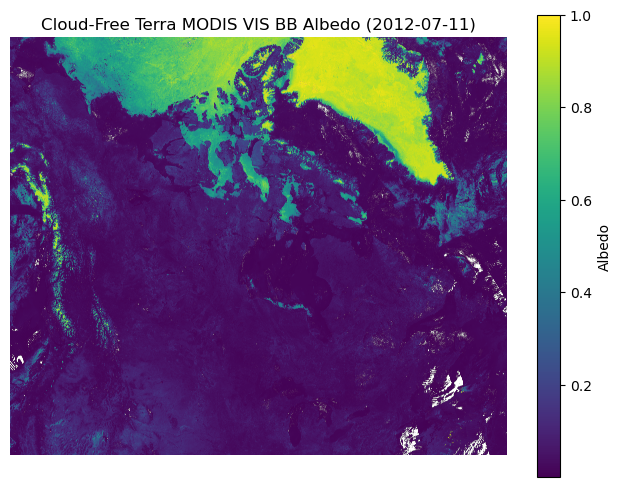

In [11]:

albedo_file = f"https://ccrs-modis-albedo.s3.ca-central-1.amazonaws.com/2012/Terra_MODIS_VIS_BB_Albedo.Noon_250m_20120711.tif"
mask_file   = f"https://ccrs-modis-albedo.s3.ca-central-1.amazonaws.com/2012/Terra_MODIS_State_Mask_250m_20120711.tif"

scale = 0.0001   # MODIS scale factor
# -----------------------------------------------------
# Load albedo
# -----------------------------------------------------
with rasterio.open(albedo_file) as src:
    albedo = src.read(1).astype("float32")
    # albedo_nodata = src.nodata

# Load state mask
with rasterio.open(mask_file) as src_mask:
    mask = src_mask.read(1).astype("uint8")
    # mask_nodata = src_mask.nodata

# Apply scale factor
albedo = albedo * scale
# albedo[albedo > 1] = np.nan ## mask invalide pixels
albedo[(albedo <= 0) | (albedo > 1)] = np.nan ## mask invalide pixels
# -----------------------------------------------------
# Cloud mask
# Cloud 10 and nodata 255
# -----------------------------------------------------
cloud_free = ((mask != 10)|(mask!=255))
albedo_masked = np.where(cloud_free, albedo, np.nan)

# -----------------------------------------------------
# Plot
# -----------------------------------------------------
plt.figure(figsize=(8, 6))
plt.imshow(albedo_masked, cmap="viridis")
plt.title("Cloud-Free Terra MODIS VIS BB Albedo (2012-07-11)")
plt.colorbar(label="Albedo")
plt.axis("off")
plt.show()

#### 9. Downloaded files like BB_Albedo file and its State_Mask to the local and display 

Downloaded: Terra_MODIS_SW_BB_Albedo.Noon_250m_20120711.tif


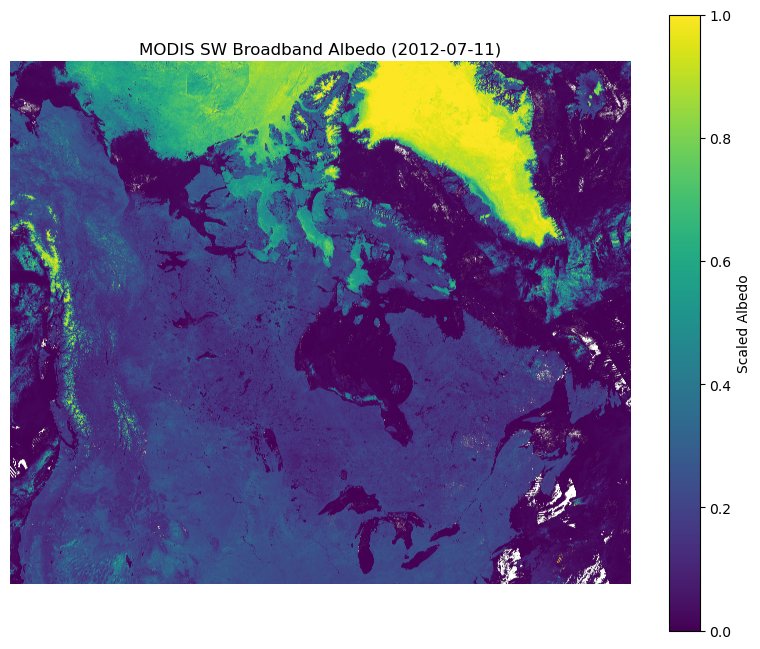

In [12]:
key = "2012/Terra_MODIS_SW_BB_Albedo.Noon_250m_20120711.tif"
local_path = "Terra_MODIS_SW_BB_Albedo.Noon_250m_20120711.tif"

s3.download_file(bucket_name, key, local_path)
print("Downloaded:", local_path)

with rasterio.open(local_path) as src:
    albedo = src.read(1).astype("float32")   

# Apply MODIS scale factor
albedo = albedo * 0.0001

# Replace invalid with NaN
# albedo[albedo >1] = np.nan
albedo[(albedo <= 0) | (albedo > 1)] = np.nan ## mask invalide pixels

# Percentile stretch for better visualization
low, high = np.nanpercentile(albedo, (2,98))
albedo_stretched = np.clip((albedo - low) / (high - low), 0, 1)

plt.figure(figsize=(10,8))
im = plt.imshow(albedo_stretched, cmap="viridis")
plt.title("MODIS SW Broadband Albedo (2012-07-11)")
plt.colorbar(im, label="Scaled Albedo")
plt.axis("off")
plt.show()


####  10. Create false-color composite image of the area for mid-summer 2012 and show the corresponding values of shortwave (SW) broadband albedo


### Q: A picture is worth a thousand words. Show us a visual (or several!) from your dataset that either illustrates something informative about your dataset, or that you think might excite someone to dig in further.

Create false-color composite image of the area for mid-summer 2012 <br>
    Load Terra_MODIS_B1_BRDF.Norm_250m_20000711.tif as BLUE(B) band <br>
    Load Terra_MODIS_B2_BRDF.Norm_250m_20000711.tif as GREE(G) band <br>
    Load Terra_MODIS_B6_BRDF.Norm_250m_20000711.tif as RED(R) band <br>
This RGB picture will show the area covered by our dataset and the distribution of typical surface features (land, water, snow, vegetation, deserted areas)
    Load Terra_MODIS_SW_BB_Albedo.Noon_250m_20120711.tif file to see the corresponding values of shortwave (SW) broadband albedo


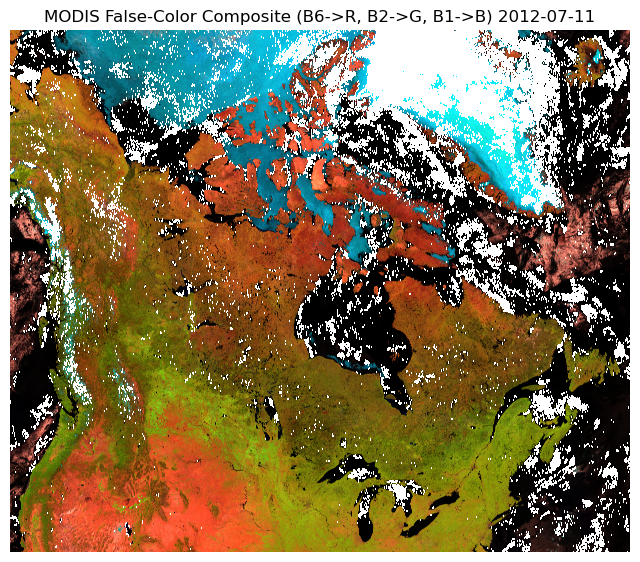

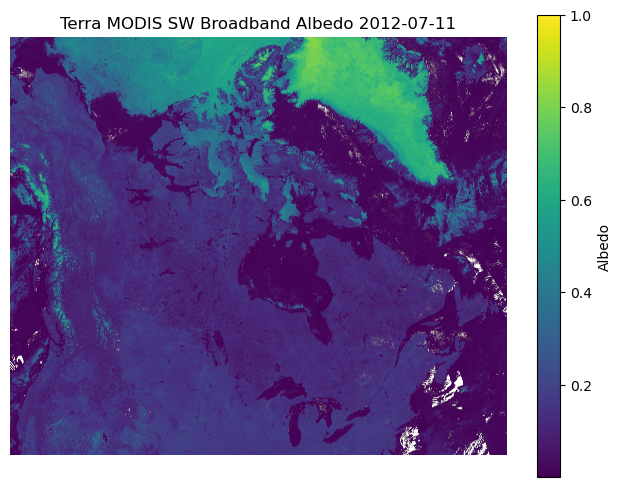

In [13]:
# False-color bands
blue_file  = f"https://ccrs-modis-albedo.s3.ca-central-1.amazonaws.com/2012/Terra_MODIS_B1_BRDF.Norm_250m_20120711.tif"
green_file = f"https://ccrs-modis-albedo.s3.ca-central-1.amazonaws.com/2012/Terra_MODIS_B2_BRDF.Norm_250m_20120711.tif"
red_file   = f"https://ccrs-modis-albedo.s3.ca-central-1.amazonaws.com/2012/Terra_MODIS_B6_BRDF.Norm_250m_20120711.tif"
mask_file   = f"https://ccrs-modis-albedo.s3.ca-central-1.amazonaws.com/2012/Terra_MODIS_State_Mask_250m_20120711.tif"

# SW BB Albedo
albedo_file = f"https://ccrs-modis-albedo.s3.ca-central-1.amazonaws.com/2012/Terra_MODIS_SW_BB_Albedo.Noon_250m_20120711.tif"
scale = 0.0001  # scale factor for albedo

# -----------------------------
# Function to read raster
# -----------------------------
def read_raster(path):
    with rasterio.open(path) as src:
        arr = src.read(1).astype('float32')
        if src.nodata is not None:
            arr[arr == src.nodata] = np.nan
    return arr
# -----------------------------
# Function to read raster with crs and transform
# -----------------------------
def read_raster2(file_path):   
    with rasterio.open(file_path) as src:
        data = src.read(1).astype('float32')
        if src.nodata is not None:
            data[data == src.nodata] = np.nan
        crs = src.crs
        transform = src.transform
    return data, crs, transform

# -----------------------------
# Read bands
# -----------------------------
B = read_raster(blue_file)* scale
G = read_raster(green_file)* scale
R = read_raster(red_file)* scale
# B*=scale
B[(B <= 0) | (B > 1)] = np.nan ## mask invalid pixels
R[(R <= 0) | (R > 1)] = np.nan ## mask invalid pixels
G[(G <= 0) | (G > 1)] = np.nan ## mask invalid pixels


# Load state mask
with rasterio.open(mask_file) as src_mask:
    mask = src_mask.read(1).astype("uint8")
    # mask_nodata = src_mask.nodata

albedo = read_raster(albedo_file) * scale  # apply scale factor
# albedo[albedo > 1] = np.nan ## mask the value greater than 1
albedo[(albedo <= 0) | (albedo > 1)] = np.nan ## mask invalide pixels


# -----------------------------------------------------
# Cloud mask
# Cloud 10 and nodata 255
# -----------------------------------------------------
cloud_free = ((mask != 10)|(mask!=255))

albedo_masked = np.where(cloud_free, albedo, np.nan)
R_masked = np.where(cloud_free, R, np.nan)
G_masked = np.where(cloud_free, G, np.nan)
B_masked = np.where(cloud_free, B, np.nan)

# -----------------------------
# Stack RGB for false-color
# -----------------------------
# Normalize each band to 0-1 for display
def normalize(array):
    min_val = np.nanpercentile(array, 2)
    max_val = np.nanpercentile(array, 98)
    return np.clip((array - min_val) / (max_val - min_val), 0, 1)

rgb_norm = np.dstack([
    normalize(R_masked),  # RED band
    normalize(G_masked),  # GREEN band
    normalize(B_masked)   # BLUE band
])

# -----------------------------
# Plot RGB composite
# -----------------------------
# print ('plotting')
plt.figure(figsize=(8, 8))
plt.imshow(rgb_norm)
plt.title("MODIS False-Color Composite (B6->R, B2->G, B1->B) 2012-07-11")
plt.axis('off')
plt.show()


# -----------------------------
# Plot SW BB Albedo
# -----------------------------
plt.figure(figsize=(8, 6))
plt.imshow(albedo, cmap='viridis')
plt.title("Terra MODIS SW Broadband Albedo 2012-07-11")
plt.colorbar(label='Albedo')
plt.axis('off')
plt.show()

#### 11. Create a subset of false composite, display it and see the corresponding values of shortwave (SW) broadband albedo

(1867, 1880, 3)


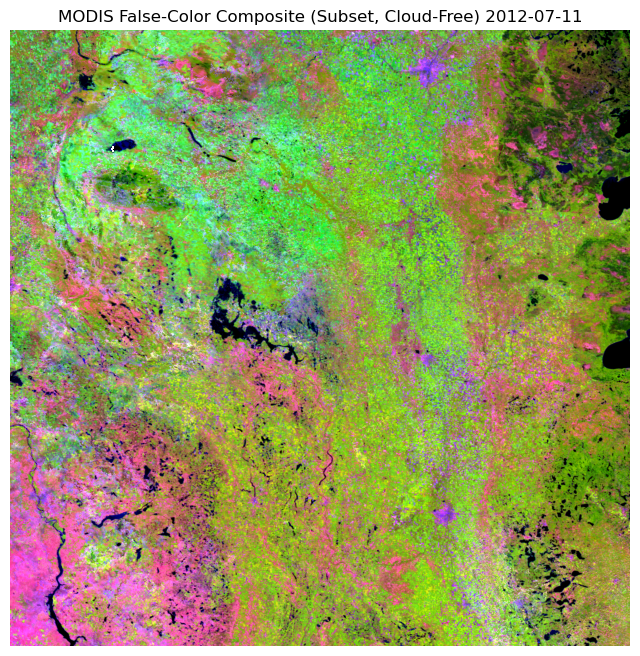

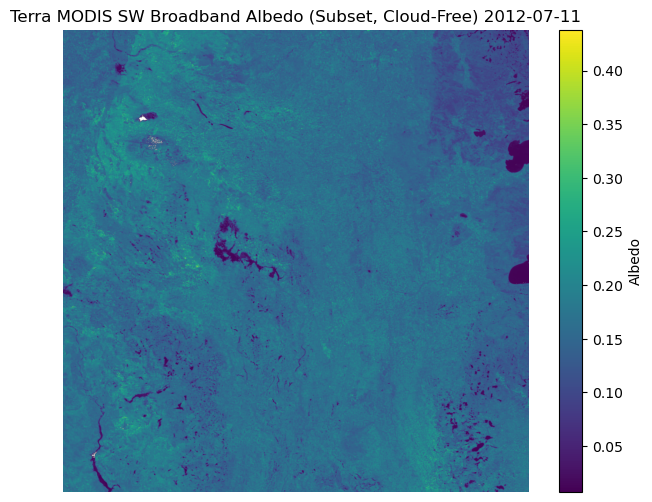

In [14]:
# False-color bands

blue_file  = f"https://ccrs-modis-albedo.s3.ca-central-1.amazonaws.com/2012/Terra_MODIS_B1_BRDF.Norm_250m_20120711.tif"
green_file = f"https://ccrs-modis-albedo.s3.ca-central-1.amazonaws.com/2012/Terra_MODIS_B2_BRDF.Norm_250m_20120711.tif"
red_file   = f"https://ccrs-modis-albedo.s3.ca-central-1.amazonaws.com/2012/Terra_MODIS_B6_BRDF.Norm_250m_20120711.tif"
mask_file   = f"https://ccrs-modis-albedo.s3.ca-central-1.amazonaws.com/2012/Terra_MODIS_State_Mask_250m_20120711.tif"

# SW BB Albedo
albedo_file = f"https://ccrs-modis-albedo.s3.ca-central-1.amazonaws.com/2012/Terra_MODIS_SW_BB_Albedo.Noon_250m_20120711.tif"

scale = 0.0001

# -----------------------------
# Define lat/lon bounding box (subset)
# -----------------------------
lon_min, lon_max = -101.0, -95.0  # degrees
lat_min, lat_max = 46.0, 50.0      # degrees

# -----------------------------
# Helper: Reproject bounding box to raster CRS
# -----------------------------
def reproject_bounds_to_raster_crs(lat_min, lat_max, lon_min, lon_max, raster_path):
    with rasterio.open(raster_path) as src:
        raster_crs = src.crs

    # Input coordinates in geographic CRS (EPSG:4326)
    xs = [lon_min, lon_max, lon_min, lon_max]
    ys = [lat_min, lat_min, lat_max, lat_max]

    # Transform to raster CRS
    xr, yr = transform("EPSG:4326", raster_crs, xs, ys)

    # Return new projected bounds
    return min(xr), min(yr), max(xr), max(yr), raster_crs

# -----------------------------
# Reproject geog → raster CRS
# -----------------------------
xmin, ymin, xmax, ymax, raster_crs = reproject_bounds_to_raster_crs(
    lat_min, lat_max, lon_min, lon_max, red_file
)
# -----------------------------
# Function to read raster subset using projected window
# -----------------------------
def read_subset(path, xmin, ymin, xmax, ymax, return_transform=False):
    with rasterio.open(path) as src:
        window = from_bounds(xmin, ymin, xmax, ymax, transform=src.transform)
        data = src.read(1, window=window).astype("float32")

        # Generate correct subset transform
        transform = src.window_transform(window)

        if return_transform:
            return data, transform, src.crs
        return data
# -----------------------------
# Read bands using correct projected window
# -----------------------------
R, subset_transform, subset_crs = read_subset(red_file, xmin, ymin, xmax, ymax, return_transform=True)
G = read_subset(green_file, xmin, ymin, xmax, ymax)
B = read_subset(blue_file, xmin, ymin, xmax, ymax)
MASK = read_subset(mask_file, xmin, ymin, xmax, ymax)
albedo = read_subset(albedo_file, xmin, ymin, xmax, ymax)

  # apply scale factor
R *= scale
G *= scale
B*=scale
albedo*=scale
# albedo[albedo > 1] = np.nan
albedo[(albedo <= 0) | (albedo > 1)] = np.nan ## mask invalide pixels
B[(B <= 0) | (B > 1)] = np.nan ## mask invalid pixels
R[(R <= 0) | (R > 1)] = np.nan ## mask invalid pixels
G[(G <= 0) | (G > 1)] = np.nan ## mask invalid pixels

# -----------------------------
# Apply cloud mask: only cloud-free pixels (cloud:=10, nodata: 255)
# -----------------------------

cloud_free = ((MASK != 10)|(MASK != 255))

# Mask RGB bands
R_masked = np.where(cloud_free, R, np.nan)
G_masked = np.where(cloud_free, G, np.nan)
B_masked = np.where(cloud_free, B, np.nan)

# # Mask albedo
albedo_masked = np.where(cloud_free, albedo, np.nan)

# -----------------------------
# Stack RGB for false-color
# -----------------------------
def normalize(array):
    min_val = np.nanpercentile(array, 2)
    max_val = np.nanpercentile(array, 98)
    return np.clip((array - min_val) / (max_val - min_val), 0, 1)

rgb = np.dstack([
    normalize(R_masked),  # RED
    normalize(G_masked),  # GREEN
    normalize(B_masked)   # BLUE
])
print (rgb.shape)

# -----------------------------
# # Plot RGB
# -----------------------------
plt.figure(figsize=(8,8))
plt.imshow(rgb)
plt.title("MODIS False-Color Composite (Subset, Cloud-Free) 2012-07-11")
plt.axis('off')
plt.show()

# # -----------------------------
# # Plot Albedo
# # -----------------------------
plt.figure(figsize=(8,6))
plt.imshow(albedo_masked, cmap='viridis')
# plt.imshow(aldedo_stretched, cmap='viridis')
plt.title("Terra MODIS SW Broadband Albedo (Subset, Cloud-Free) 2012-07-11")
plt.colorbar(label='Albedo')
plt.axis('off')
plt.show()

#### 12. Create a false cloud free composite and save it in a local drive

In [15]:
# False-color bands
blue_file  = f"https://ccrs-modis-albedo.s3.ca-central-1.amazonaws.com/2012/Terra_MODIS_B1_BRDF.Norm_250m_20120711.tif"
green_file = f"https://ccrs-modis-albedo.s3.ca-central-1.amazonaws.com/2012/Terra_MODIS_B2_BRDF.Norm_250m_20120711.tif"
red_file   = f"https://ccrs-modis-albedo.s3.ca-central-1.amazonaws.com/2012/Terra_MODIS_B6_BRDF.Norm_250m_20120711.tif"
mask_file   = f"https://ccrs-modis-albedo.s3.ca-central-1.amazonaws.com/2012/Terra_MODIS_State_Mask_250m_20120711.tif"

scale = 0.0001  # scale factor for albedo

# -----------------------------
# Function to read raster
# -----------------------------
def read_raster(path):
    with rasterio.open(path) as src:
        arr = src.read(1).astype('float32')
        if src.nodata is not None:
            arr[arr == src.nodata] = np.nan
    return arr

# -----------------------------
# Function to read raster to return crs and transform
# -----------------------------

def read_raster2(file_path):
     
    with rasterio.open(file_path) as src:
        data = src.read(1).astype('float32')
        # if src.nodata is not None:
        #     data[data == src.nodata] = np.nan
        crs = src.crs
        transform = src.transform
    return data, crs, transform

# -----------------------------
# Read bands
# -----------------------------
# B = read_raster(blue_file)* scale
B, B_CRS, B_transform = read_raster2(blue_file)
G = read_raster(green_file)* scale
R = read_raster(red_file)* scale
B*=scale


# Load state mask
with rasterio.open(mask_file) as src_mask:
    mask = src_mask.read(1).astype("uint8")
    # mask_nodata = src_mask.nodata

albedo = read_raster(albedo_file) * scale  # apply scale factor

# albedo[albedo > 1] = np.nan
albedo[(albedo <= 0) | (albedo > 1)] = np.nan ## mask invalide pixels
B[(B <= 0) | (B > 1)] = np.nan ## mask invalid pixels
R[(R <= 0) | (R > 1)] = np.nan ## mask invalid pixels
G[(G <= 0) | (G > 1)] = np.nan ## mask invalid pixels


# -----------------------------------------------------
# Cloud mask
# Cloud 10 and nodata 255
# -----------------------------------------------------
cloud_free = ((mask != 10)|(mask!=255))

albedo_masked = np.where(cloud_free, albedo, np.nan)
R_masked = np.where(cloud_free, R, np.nan)
G_masked = np.where(cloud_free, G, np.nan)
B_masked = np.where(cloud_free, B, np.nan)


### for creating rgb composite

rgb = np.dstack([
    R_masked,  # RED band
    G_masked,  # GREEN band
    B_masked   # BLUE band
])
# # -----------------------------
out_file = "MODIS_BRDF_Norm_RGB_20120711_cloudfree.tif"

with rasterio.open(
    out_file,
    "w",
    driver="GTiff",
    height=rgb.shape[0],
    width=rgb.shape[1],
    count=3,
    dtype="float32",
    transform=B_transform,
    crs=B_CRS,
) as dst:
    dst.write(rgb[:, :, 0], 1)
    dst.write(rgb[:, :, 1], 2)
    dst.write(rgb[:, :, 2], 3)

print(f"Saved RGB subset to: {out_file}")

Saved RGB subset to: MODIS_BRDF_Norm_RGB_20120711_cloudfree.tif


#### 13. Create a subset of false composite and save it in a local drive

In [16]:
# False-color bands

blue_file  = f"https://ccrs-modis-albedo.s3.ca-central-1.amazonaws.com/2012/Terra_MODIS_B1_BRDF.Norm_250m_20120711.tif"
green_file = f"https://ccrs-modis-albedo.s3.ca-central-1.amazonaws.com/2012/Terra_MODIS_B2_BRDF.Norm_250m_20120711.tif"
red_file   = f"https://ccrs-modis-albedo.s3.ca-central-1.amazonaws.com/2012/Terra_MODIS_B6_BRDF.Norm_250m_20120711.tif"
mask_file   = f"https://ccrs-modis-albedo.s3.ca-central-1.amazonaws.com/2012/Terra_MODIS_State_Mask_250m_20120711.tif"

scale = 0.0001

# -----------------------------
# Define lat/lon bounding box (subset)
# -----------------------------
lon_min, lon_max = -101.0, -95.0  # degrees
lat_min, lat_max = 46.0, 50.0      # degrees

# -----------------------------
# Helper: Reproject bounding box to raster CRS
# -----------------------------
def reproject_bounds_to_raster_crs(lat_min, lat_max, lon_min, lon_max, raster_path):
    with rasterio.open(raster_path) as src:
        raster_crs = src.crs

    # Input coordinates in geographic CRS (EPSG:4326)
    xs = [lon_min, lon_max, lon_min, lon_max]
    ys = [lat_min, lat_min, lat_max, lat_max]

    # Transform to raster CRS
    xr, yr = transform("EPSG:4326", raster_crs, xs, ys)

    # Return new projected bounds
    return min(xr), min(yr), max(xr), max(yr), raster_crs

# -----------------------------
# Reproject geog → raster CRS
# -----------------------------
xmin, ymin, xmax, ymax, raster_crs = reproject_bounds_to_raster_crs(
    lat_min, lat_max, lon_min, lon_max, red_file
)
# -----------------------------
# Function to read raster subset using projected window
# -----------------------------
def read_subset(path, xmin, ymin, xmax, ymax, return_transform=False):
    with rasterio.open(path) as src:
        window = from_bounds(xmin, ymin, xmax, ymax, transform=src.transform)
        data = src.read(1, window=window).astype("float32")

        # Generate correct subset transform
        transform = src.window_transform(window)

        if return_transform:
            return data, transform, src.crs
        return data
# -----------------------------
# Read bands using correct projected window
# -----------------------------
R, subset_transform, subset_crs = read_subset(red_file, xmin, ymin, xmax, ymax, return_transform=True)
G = read_subset(green_file, xmin, ymin, xmax, ymax)
B = read_subset(blue_file, xmin, ymin, xmax, ymax)
MASK = read_subset(mask_file, xmin, ymin, xmax, ymax)

  # apply scale factor
R *= scale
G *= scale
B*=scale


B[(B <= 0) | (B > 1)] = np.nan ## mask invalid pixels
R[(R <= 0) | (R > 1)] = np.nan ## mask invalid pixels
G[(G <= 0) | (G > 1)] = np.nan ## mask invalid pixels

# -----------------------------
# Apply cloud mask: only cloud-free pixels (mask==10)
# -----------------------------
# # cloud_free = (mask != 10)
cloud_free = ((MASK != 10)|(MASK != 255))

# Mask RGB bands
R_masked = np.where(cloud_free, R, np.nan)
G_masked = np.where(cloud_free, G, np.nan)
B_masked = np.where(cloud_free, B, np.nan)


rgb = np.dstack([
    R_masked,  # RED
    G_masked,  # GREEN
   B_masked   # BLUE
])


# -----------------------------
# Save RGB as a 3-band GeoTIFF
# -----------------------------
out_file = "MODIS_RGB_Subset_20120711.tif"


with rasterio.open(
    out_file,
    "w",
    driver="GTiff",
    height=rgb.shape[0],
    width=rgb.shape[1],
    count=3,
    dtype="float32",
    transform=subset_transform,
    crs=subset_crs,
) as dst:
    dst.write(rgb[:, :, 0], 1)
    dst.write(rgb[:, :, 1], 2)
    dst.write(rgb[:, :, 2], 3)

print(f"Saved RGB subset to: {out_file}")

Saved RGB subset to: MODIS_RGB_Subset_20120711.tif




### Q: What is one question that you have answered using these data? Can you show us how you came to that answer?

These data have been used to study the Minimum Snow/Ice (MSI) extent variations, quantifying the rate of declining the Artic and alpine glaciated areas of North America, as well as climate impacts of radiative forcing driven by agricultural land-use and land-cover changes.




### Q: What is one unanswered question that you think could be answered using these data? Do you have any recommendations or advice for someone wanting to answer this question?

What new can we learn from these data about reflectance and albedo for water/ocean surface. 